<a href="https://colab.research.google.com/github/SamAdebisi/Stable_Diffusion/blob/main/deep/deep_dive2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q --upgrade transformers==4.36.2 diffusers ftfy accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5

In [1]:
from base64 import b64encode

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os

torch.manual_seed(1)
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if "mps" == torch_device: os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"

In [ ]:
# pip uninstall transformers -y

In [ ]:
# pip install transformers==4.36.2

In [3]:
pip install --upgrade diffusers transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 32.3 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.2
    Uninstalling tokenizers-0.15.2:
      Successfully uninstalled tokenizers-0.15.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.36.2
    Uninstalling transformers-4.36.2:
      Successfully uninstalled transformers-4.36.2


In [2]:
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

<ipython-input-3-dbcc7b5dbc4f>:31: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

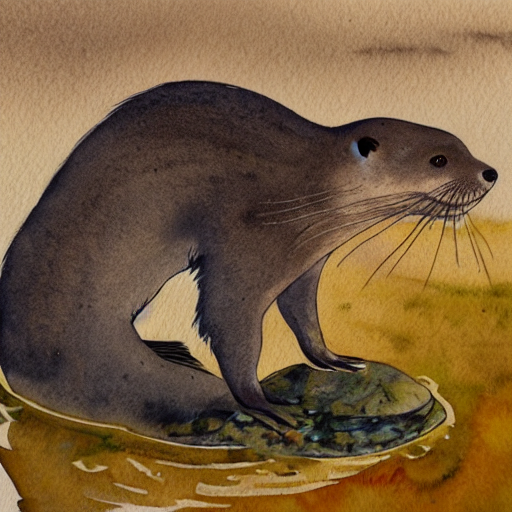

In [3]:
# Some settings
prompt = ["A watercolor painting of an otter"]
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 30            # Number of denoising steps
guidance_scale = 7.5                # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

# Prep text
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32) # minor fix to ensure MPS compatibility, fixed in diffusers PR 3925

set_timesteps(scheduler,num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma # Scaling (previous versions did latents = latents * self.scheduler.sigmas[0]

# Loop
with autocast("cuda"):  # will fallback to CPU if no CUDA; no autocast for MPS
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        # Scale the latents (preconditioning):
        # latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5) # Diffusers 0.3 and below
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        # latents = scheduler.step(noise_pred, i, latents)["prev_sample"] # Diffusers 0.3 and below
        latents = scheduler.step(noise_pred, t, latents).prev_sample

# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

# Display
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

In [4]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images



In [5]:
# Download a demo Image
!curl --output macaw.jpg 'https://lafeber.com/pet-birds/wp-content/uploads/2018/06/Scarlet-Macaw-2.jpg'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 58602  100 58602    0     0   196k      0 --:--:-- --:--:-- --:--:--  196k


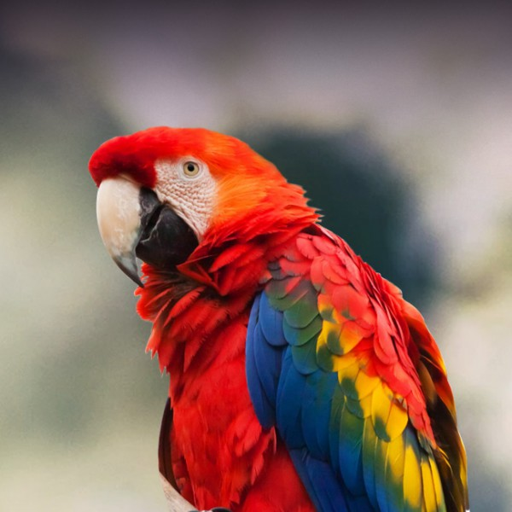

In [6]:
# Load the image with PIL
input_image = Image.open('macaw.jpg').resize((512, 512))
input_image

In [7]:
# Encode to the latent space
encoded = pil_to_latent(input_image)
encoded.shape

torch.Size([1, 4, 64, 64])

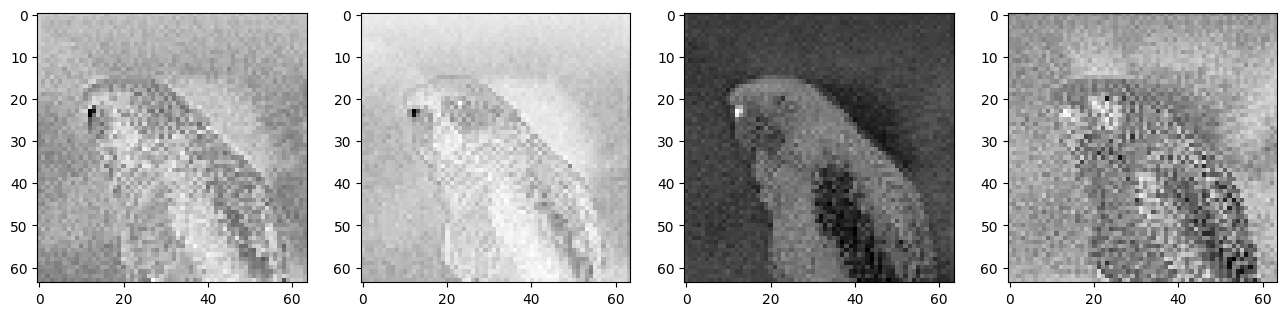

In [8]:
# Let's visualize the four channels of this latent representation:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(encoded[0][c].cpu(), cmap='Greys')

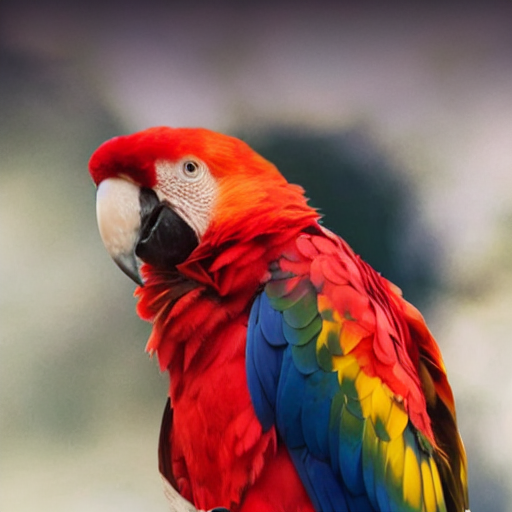

In [9]:
# Decode this latent representation back into an image
decoded = latents_to_pil(encoded)[0]
decoded

# Setting the number of sampling steps:


In [11]:
set_timesteps(scheduler, 15)

In [13]:
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

In [14]:
scheduler.set_timesteps

<bound method LMSDiscreteScheduler.set_timesteps of LMSDiscreteScheduler {
  "_class_name": "LMSDiscreteScheduler",
  "_diffusers_version": "0.33.1",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "steps_offset": 0,
  "timestep_spacing": "linspace",
  "trained_betas": null,
  "use_beta_sigmas": false,
  "use_exponential_sigmas": false,
  "use_karras_sigmas": false
}
>

In [15]:
# See these in terms of the original 1000 steps used for training:
print(scheduler.timesteps)

tensor([999., 998., 997., 996., 995., 994., 993., 992., 991., 990., 989., 988.,
        987., 986., 985., 984., 983., 982., 981., 980., 979., 978., 977., 976.,
        975., 974., 973., 972., 971., 970., 969., 968., 967., 966., 965., 964.,
        963., 962., 961., 960., 959., 958., 957., 956., 955., 954., 953., 952.,
        951., 950., 949., 948., 947., 946., 945., 944., 943., 942., 941., 940.,
        939., 938., 937., 936., 935., 934., 933., 932., 931., 930., 929., 928.,
        927., 926., 925., 924., 923., 922., 921., 920., 919., 918., 917., 916.,
        915., 914., 913., 912., 911., 910., 909., 908., 907., 906., 905., 904.,
        903., 902., 901., 900., 899., 898., 897., 896., 895., 894., 893., 892.,
        891., 890., 889., 888., 887., 886., 885., 884., 883., 882., 881., 880.,
        879., 878., 877., 876., 875., 874., 873., 872., 871., 870., 869., 868.,
        867., 866., 865., 864., 863., 862., 861., 860., 859., 858., 857., 856.,
        855., 854., 853., 852., 851., 85

In [16]:
# Look at the equivalent noise levels:
print(scheduler.sigmas)

tensor([14.6146, 14.5263, 14.4386,  ...,  0.0413,  0.0292,  0.0000])


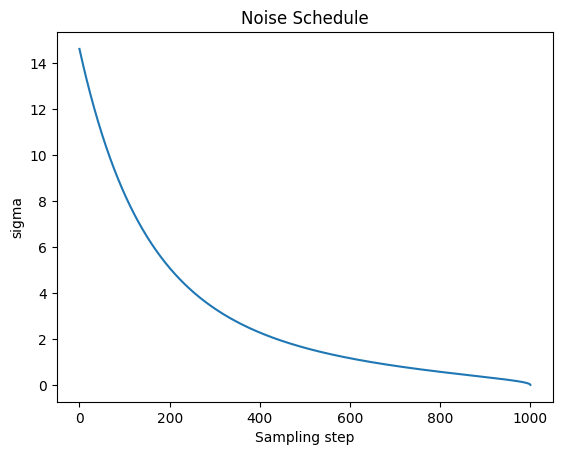

In [17]:
# Plotting this noise schedule:
plt.plot(scheduler.sigmas)
plt.title('Noise Schedule')
plt.xlabel('Sampling step')
plt.ylabel('sigma')
plt.show()

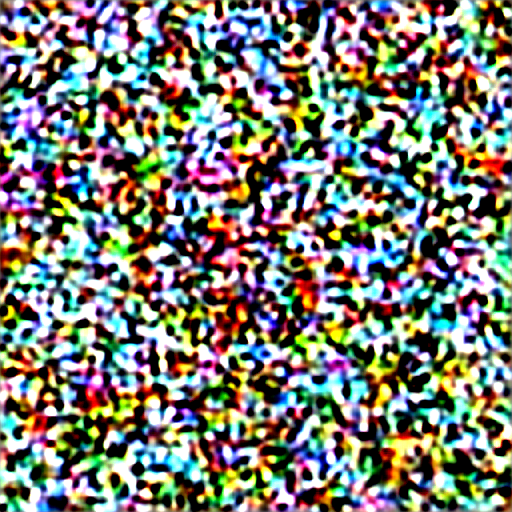

In [18]:
noise = torch.randn_like(encoded) # Random noise
sampling_step = 10 # Equivalent to step 10 out of 15 in the schedule above
# encoded_and_noised = scheduler.add_noise(encoded, noise, timestep) # Diffusers 0.3 and below
encoded_and_noised = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([scheduler.timesteps[sampling_step]]))
latents_to_pil(encoded_and_noised.float())[0] # Display

In [21]:
timesteps = torch.tensor([30]).to(latents.device)

In [22]:
noised_latents = scheduler.add_noise(latents, noise, timesteps)

In [23]:
noised_latents

tensor([[[[ 0.1566,  1.3694,  3.3166,  ...,  3.2827,  2.4568,  3.7464],
          [ 0.2123,  0.1260, -2.1838,  ...,  3.8670,  0.8749,  3.1624],
          [ 0.8940, -2.6044,  3.1585,  ...,  2.6612,  2.9895,  1.6997],
          ...,
          [ 3.0583,  1.2583,  4.9058,  ...,  3.5990,  1.7647,  4.4480],
          [ 5.1450,  4.8202, -2.8313,  ...,  1.9074,  2.6354,  4.1824],
          [ 4.1450,  2.9419,  7.6990,  ...,  1.8433,  2.0234,  2.6798]],

         [[ 3.5267,  2.5505,  0.9040,  ...,  6.7898,  4.8802,  5.5289],
          [-1.2993,  0.8050,  4.1835,  ...,  4.3394,  4.2105,  5.2022],
          [ 2.1124,  3.3649,  1.3668,  ...,  4.0968,  3.5475,  4.4685],
          ...,
          [ 2.1996,  7.0944, -4.2369,  ..., -1.1032,  3.4695,  0.6660],
          [ 4.3147, 10.5776,  7.4167,  ..., -0.1396,  2.2815,  3.1228],
          [ 1.6737,  8.0416, -6.4406,  ...,  1.6857,  0.1909,  1.0284]],

         [[-4.4039, -0.4354, -1.4747,  ..., -4.4693, -1.4674, -5.4036],
          [-0.7326, -4.6884, -

In [29]:
#sigmas = scheduler.sigmas[timesteps].to(latents.device)

sigmas = scheduler.sigmas.to(latents.device)[timesteps]
noisy_samples = latents + noise * sigmas[:, None, None, None]  # broadcast over latent dimensions

In [31]:
noisy_samples

tensor([[[[ -1.6063,  14.8607,  -0.7557,  ...,  -1.4662,   9.1639,  -7.1494],
          [-10.5029,   0.3687, -26.8762,  ...,  -1.8826, -21.7697,  19.6103],
          [  4.0842,  -0.5302,   9.1617,  ...,  12.4939,  -5.8336, -11.1040],
          ...,
          [ 11.8216, -18.6065,   0.7943,  ..., -13.0660,  10.6465,   4.6831],
          [ 34.7525,   0.5685,   5.2951,  ..., -11.1997,  20.4969,   4.1118],
          [ 10.9379,  10.8189,  -0.1030,  ...,  -3.6319,  -4.5997,  14.8621]],

         [[ 12.2401,   8.1377,  13.4505,  ...,  14.8140,  14.4427,   2.5204],
          [ -6.6846,  -0.6541, -17.6939,  ...,  -2.9556,   8.5935,   8.1404],
          [  5.6187,  -5.8982,   7.2724,  ...,   3.7885, -21.3209,   6.4730],
          ...,
          [ -9.4954,  -4.2455,  -7.5976,  ...,  -1.9760, -10.5548, -12.8757],
          [  6.8755,  11.9153,   0.7162,  ...,  22.4632,  13.5289,  -4.9024],
          [-27.9567,   4.2670,  11.5178,  ...,  12.5653,   7.1043,  -4.8891]],

         [[-10.0866,  -1.1213,

In [33]:
latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

In [34]:
latent_model_input

tensor([[[[ 0.0254,  0.2118,  0.6201,  ...,  0.6154,  0.4295,  0.7092],
          [ 0.0699,  0.0287, -0.3303,  ...,  0.7145,  0.2159,  0.5344],
          [ 0.1511, -0.4868,  0.5692,  ...,  0.4603,  0.5637,  0.3401],
          ...,
          [ 0.5368,  0.2685,  0.9008,  ...,  0.6974,  0.2998,  0.8099],
          [ 0.8600,  0.8846, -0.5360,  ...,  0.3785,  0.4320,  0.7617],
          [ 0.7432,  0.5189,  1.4198,  ...,  0.3476,  0.3862,  0.4540]],

         [[ 0.6124,  0.4483,  0.1358,  ...,  1.2235,  0.8697,  1.0140],
          [-0.2283,  0.1527,  0.8193,  ...,  0.8086,  0.7502,  0.9421],
          [ 0.3763,  0.6390,  0.2413,  ...,  0.7495,  0.7076,  0.8095],
          ...,
          [ 0.4293,  1.3147, -0.7602,  ..., -0.2020,  0.6661,  0.1571],
          [ 0.7716,  1.9140,  1.3697,  ..., -0.0856,  0.3880,  0.5896],
          [ 0.3957,  1.4773, -1.2156,  ...,  0.2782,  0.0147,  0.2014]],

         [[-0.7947, -0.0781, -0.2613,  ..., -0.7993, -0.2921, -0.9801],
          [-0.1479, -0.8313, -

In [35]:
latent_model_input = scheduler.scale_model_input(latent_model_input, t)

In [36]:
latent_model_input

tensor([[[[ 0.0254,  0.2117,  0.6199,  ...,  0.6151,  0.4293,  0.7089],
          [ 0.0698,  0.0287, -0.3301,  ...,  0.7142,  0.2158,  0.5341],
          [ 0.1510, -0.4865,  0.5689,  ...,  0.4601,  0.5634,  0.3399],
          ...,
          [ 0.5366,  0.2684,  0.9005,  ...,  0.6971,  0.2997,  0.8096],
          [ 0.8596,  0.8842, -0.5358,  ...,  0.3783,  0.4318,  0.7613],
          [ 0.7429,  0.5186,  1.4192,  ...,  0.3475,  0.3861,  0.4538]],

         [[ 0.6122,  0.4481,  0.1357,  ...,  1.2230,  0.8693,  1.0135],
          [-0.2282,  0.1526,  0.8189,  ...,  0.8082,  0.7499,  0.9417],
          [ 0.3761,  0.6387,  0.2412,  ...,  0.7492,  0.7073,  0.8091],
          ...,
          [ 0.4291,  1.3142, -0.7599,  ..., -0.2020,  0.6658,  0.1571],
          [ 0.7712,  1.9131,  1.3692,  ..., -0.0856,  0.3878,  0.5894],
          [ 0.3955,  1.4767, -1.2150,  ...,  0.2781,  0.0147,  0.2013]],

         [[-0.7943, -0.0780, -0.2612,  ..., -0.7990, -0.2920, -0.9797],
          [-0.1478, -0.8309, -

  0%|          | 0/50 [00:00<?, ?it/s]

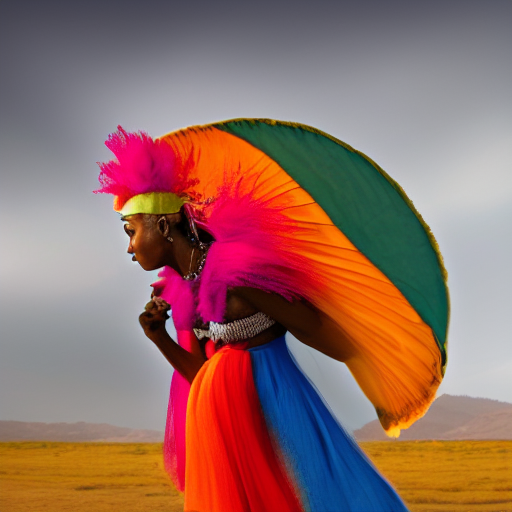

In [37]:
# Settings (same as before except for the new prompt)
prompt = ["A colorful dancer, nat geo photo"]
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50            # Number of denoising steps
guidance_scale = 8                  # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

# Prep text (same as before)
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler (setting the number of inference steps)
set_timesteps(scheduler, num_inference_steps)

# Prep latents (noising appropriately for start_step)
start_step = 10
start_sigma = scheduler.sigmas[start_step]
noise = torch.randn_like(encoded)
latents = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([scheduler.timesteps[start_step]]))
latents = latents.to(torch_device).float()

# Loop
for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    if i >= start_step: # << This is the only modification to the loop we do

        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

latents_to_pil(latents)[0]

In [38]:
# Our text prompt
prompt = 'A picture of a puppy'

In [39]:
# Turn the text into a sequnce of tokens:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_input['input_ids'][0] # View the tokens

tensor([49406,   320,  1674,   539,   320,  6829, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407])

In [40]:
# See the individual tokens
for t in text_input['input_ids'][0][:8]: # We'll just look at the first 7 to save you from a wall of '<|endoftext|>'
    print(t, tokenizer.decoder.get(int(t)))

tensor(49406) <|startoftext|>
tensor(320) a</w>
tensor(1674) picture</w>
tensor(539) of</w>
tensor(320) a</w>
tensor(6829) puppy</w>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>


In [41]:
# Grab the output embeddings
output_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
print('Shape:', output_embeddings.shape)
output_embeddings

Shape: torch.Size([1, 77, 768])


tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.6942,  0.3538,  1.0991,  ..., -1.5716, -1.2643, -0.0121],
         ...,
         [-0.0221, -0.0053, -0.0089,  ..., -0.7303, -1.3830, -0.3011],
         [-0.0062, -0.0246,  0.0065,  ..., -0.7326, -1.3745, -0.2953],
         [-0.0536,  0.0269,  0.0444,  ..., -0.7159, -1.3634, -0.3075]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

In [42]:
text_encoder.text_model.embeddings

CLIPTextEmbeddings(
  (token_embedding): Embedding(49408, 768)
  (position_embedding): Embedding(77, 768)
)

In [43]:
# Access the embedding layer
token_emb_layer = text_encoder.text_model.embeddings.token_embedding
token_emb_layer # Vocab size 49408, emb_dim 768

Embedding(49408, 768)

In [44]:
# Embed a token - in this case the one for 'puppy'
embedding = token_emb_layer(torch.tensor(6829, device=torch_device))
embedding.shape # 768-dim representation

torch.Size([768])

In [45]:
token_embeddings = token_emb_layer(text_input.input_ids.to(torch_device))
print(token_embeddings.shape) # batch size 1, 77 tokens, 768 values for each
token_embeddings

torch.Size([1, 77, 768])


tensor([[[ 0.0011,  0.0032,  0.0003,  ..., -0.0018,  0.0003,  0.0019],
         [ 0.0013, -0.0011, -0.0126,  ..., -0.0124,  0.0120,  0.0080],
         [ 0.0235, -0.0118,  0.0110,  ...,  0.0049,  0.0078,  0.0160],
         ...,
         [ 0.0012,  0.0077, -0.0011,  ..., -0.0015,  0.0009,  0.0052],
         [ 0.0012,  0.0077, -0.0011,  ..., -0.0015,  0.0009,  0.0052],
         [ 0.0012,  0.0077, -0.0011,  ..., -0.0015,  0.0009,  0.0052]]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)

In [46]:
pos_emb_layer = text_encoder.text_model.embeddings.position_embedding
pos_emb_layer

Embedding(77, 768)

In [47]:
position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
position_embeddings = pos_emb_layer(position_ids)
print(position_embeddings.shape)
position_embeddings

torch.Size([1, 77, 768])


tensor([[[ 0.0016,  0.0020,  0.0002,  ..., -0.0013,  0.0008,  0.0015],
         [ 0.0042,  0.0029,  0.0002,  ...,  0.0010,  0.0015, -0.0012],
         [ 0.0018,  0.0007, -0.0012,  ..., -0.0029, -0.0009,  0.0026],
         ...,
         [ 0.0216,  0.0055, -0.0101,  ..., -0.0065, -0.0029,  0.0037],
         [ 0.0188,  0.0073, -0.0077,  ..., -0.0025, -0.0009,  0.0057],
         [ 0.0330,  0.0281,  0.0289,  ...,  0.0160,  0.0102, -0.0310]]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)

In [48]:
# And combining them we get the final input embeddings
input_embeddings = token_embeddings + position_embeddings
print(input_embeddings.shape)
input_embeddings

torch.Size([1, 77, 768])


tensor([[[ 2.6770e-03,  5.2133e-03,  4.9323e-04,  ..., -3.1321e-03,
           1.0659e-03,  3.4316e-03],
         [ 5.5371e-03,  1.7510e-03, -1.2381e-02,  ..., -1.1410e-02,
           1.3508e-02,  6.8378e-03],
         [ 2.5356e-02, -1.1019e-02,  9.7663e-03,  ...,  1.9460e-03,
           6.8375e-03,  1.8573e-02],
         ...,
         [ 2.2781e-02,  1.3262e-02, -1.1241e-02,  ..., -8.0054e-03,
          -2.0560e-03,  8.9366e-03],
         [ 2.0026e-02,  1.5015e-02, -8.7638e-03,  ..., -4.0313e-03,
           1.8487e-05,  1.0885e-02],
         [ 3.4206e-02,  3.5826e-02,  2.7768e-02,  ...,  1.4465e-02,
           1.1110e-02, -2.5745e-02]]], device='cuda:0', grad_fn=<AddBackward0>)

In [49]:
# The following combines all the above steps (but doesn't let us fiddle with them!)
text_encoder.text_model.embeddings(text_input.input_ids.to(torch_device))

tensor([[[ 2.6770e-03,  5.2133e-03,  4.9323e-04,  ..., -3.1321e-03,
           1.0659e-03,  3.4316e-03],
         [ 5.5371e-03,  1.7510e-03, -1.2381e-02,  ..., -1.1410e-02,
           1.3508e-02,  6.8378e-03],
         [ 2.5356e-02, -1.1019e-02,  9.7663e-03,  ...,  1.9460e-03,
           6.8375e-03,  1.8573e-02],
         ...,
         [ 2.2781e-02,  1.3262e-02, -1.1241e-02,  ..., -8.0054e-03,
          -2.0560e-03,  8.9366e-03],
         [ 2.0026e-02,  1.5015e-02, -8.7638e-03,  ..., -4.0313e-03,
           1.8487e-05,  1.0885e-02],
         [ 3.4206e-02,  3.5826e-02,  2.7768e-02,  ...,  1.4465e-02,
           1.1110e-02, -2.5745e-02]]], device='cuda:0', grad_fn=<AddBackward0>)

In [51]:
def build_causal_attention_mask(bsz, seq_len, dtype, device):
    mask = torch.full((bsz, 1, seq_len, seq_len), float("-inf"), dtype=dtype, device=device)
    mask = torch.triu(mask, diagonal=1)
    return mask

In [52]:
def get_output_embeds(input_embeddings):
    # CLIP's text model uses causal mask, so we prepare it here:
    bsz, seq_len = input_embeddings.shape[:2]
    # causal_attention_mask = text_encoder.text_model._build_causal_attention_mask(bsz, seq_len, dtype=input_embeddings.dtype)

    causal_attention_mask = build_causal_attention_mask(
    bsz, seq_len, dtype=input_embeddings.dtype, device=input_embeddings.device
    )

    # Getting the output embeddings involves calling the model with passing output_hidden_states=True
    # so that it doesn't just return the pooled final predictions:
    encoder_outputs = text_encoder.text_model.encoder(
        inputs_embeds=input_embeddings,
        attention_mask=None, # We aren't using an attention mask so that can be None
        causal_attention_mask=causal_attention_mask.to(torch_device),
        output_attentions=None,
        output_hidden_states=True, # We want the output embs not the final output
        return_dict=None,
    )

    # We're interested in the output hidden state only
    output = encoder_outputs[0]

    # There is a final layer norm we need to pass these through
    output = text_encoder.text_model.final_layer_norm(output)

    # And now they're ready!
    return output

out_embs_test = get_output_embeds(input_embeddings) # Feed through the model with our new function
print(out_embs_test.shape) # Check the output shape
out_embs_test # Inspect the output

torch.Size([1, 77, 768])


tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.6942,  0.3538,  1.0991,  ..., -1.5716, -1.2643, -0.0121],
         ...,
         [-0.0221, -0.0053, -0.0089,  ..., -0.7303, -1.3830, -0.3011],
         [-0.0062, -0.0246,  0.0065,  ..., -0.7326, -1.3745, -0.2953],
         [-0.0536,  0.0269,  0.0444,  ..., -0.7159, -1.3634, -0.3075]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

In [53]:
prompt = 'A picture of a puppy'

# Tokenize
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding. In this case just the input embedding of token 2368...
replacement_token_embedding = text_encoder.get_input_embeddings()(torch.tensor(2368, device=torch_device))

# Insert this into the token embeddings (
token_embeddings[0, torch.where(input_ids[0]==6829)] = replacement_token_embedding.to(torch_device)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

print(modified_output_embeddings.shape)
modified_output_embeddings

torch.Size([1, 77, 768])


tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.6942,  0.3538,  1.0991,  ..., -1.5716, -1.2643, -0.0121],
         ...,
         [-0.6034, -0.5322,  0.0629,  ..., -0.3964,  0.0877, -0.9558],
         [-0.5936, -0.5407,  0.0731,  ..., -0.3876,  0.0906, -0.9436],
         [-0.6393, -0.4703,  0.1103,  ..., -0.3904,  0.1351, -0.9726]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

In [54]:
#Generating an image with these modified embeddings

def generate_with_embs(text_embeddings):
    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    num_inference_steps = 30            # Number of denoising steps
    guidance_scale = 7.5                # Scale for classifier-free guidance
    generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
    batch_size = 1

    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    set_timesteps(scheduler, num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    return latents_to_pil(latents)[0]
